# Patch creation

Extract the patches for training and tesing from the vector sample masks and image files. Uses `.vrt` image format to avoid any issues on tile joins.

In [ ]:
import os
import rioxarray as rio
import numpy as np
from geocube.api.core import make_geocube
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
import pandas as pd
import sys
import random
sys.path.append('../cnn-land-cover/scripts')
import land_cover_analysis as lca

os.environ["GTIFF_SRS_SOURCE"] = 'EPSG' # This is annoying


/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


#### Quick step to reduce short term faff ;) - uses points inside polygons to select the sample squares with data an a random split 80/20 for training


No longer needed

In [ ]:
##### Not using this script, but keeping it for reference #####

# Define paths
PATH = '../data'  # Modify to your actual data path if needed
SAMPLEDATA = os.path.join(PATH)
POINTS_FILE = os.path.join(SAMPLEDATA, 'sample_points.shp')
GRID_FILE = os.path.join(SAMPLEDATA, 'sample_sqs.shp')
TRAIN_OUTPUT = os.path.join(SAMPLEDATA, 'sample_sqi_train.shp')
TEST_OUTPUT = os.path.join(SAMPLEDATA, 'sample_sqi_test.shp')

# Load the points and grid shapefiles
points_gdf = gpd.read_file(POINTS_FILE)
grid_gdf = gpd.read_file(GRID_FILE)

# Ensure the CRS (coordinate reference system) matches
if points_gdf.crs != grid_gdf.crs:
    points_gdf = points_gdf.to_crs(grid_gdf.crs)

# Perform spatial join to find which grid cells intersect with any points
intersected_grids = gpd.sjoin(grid_gdf, points_gdf, how='inner', op='intersects')

# Drop duplicates to ensure each grid cell appears only once
unique_grids = intersected_grids.drop_duplicates(subset=grid_gdf.geometry.name)

# Randomly shuffle the unique grid cells
unique_grids = unique_grids.sample(frac=1, random_state=42).reset_index(drop=True)

# Determine 80/20 split index
split_index = int(0.8 * len(unique_grids))

# Split into training and testing sets
train_gdf = unique_grids.iloc[:split_index]
test_gdf = unique_grids.iloc[split_index:]

# Save the train and test sets to new shapefiles
train_gdf.to_file(TRAIN_OUTPUT)
test_gdf.to_file(TEST_OUTPUT)

print(f"Training shapefile (grid cells) saved to: {TRAIN_OUTPUT}")
print(f"Testing shapefile (grid cells) saved to: {TEST_OUTPUT}")

Training shapefile (grid cells) saved to: ../data/sample_sqi_train.shp
Testing shapefile (grid cells) saved to: ../data/sample_sqi_test.shp


/home/david/anaconda3/envs/geo/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_53803/1363796788.py:34: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  train_gdf.to_file(TRAIN_OUTPUT)
/tmp/ipykernel_53803/1363796788.py:35: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  test_gdf.to_file(TEST_OUTPUT)


In [ ]:
## lets add a unique number
# Define paths to the shapefiles
train_shapefile_path = '../content/labels_eco/sample_sqs_train.shp'
test_shapefile_path = '../content/labels_eco/sample_sqs_test.shp'

def add_unique_id_column(shapefile_path, column_name='unique_id'):
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Add a new unique integer column
    gdf[column_name] = range(1, len(gdf) + 1)
    
    # Overwrite the original shapefile with the new column
    gdf.to_file(shapefile_path, driver='ESRI Shapefile')
    print(f"Updated {shapefile_path} with new column '{column_name}'.")

# Add unique ID to both train and test shapefiles
add_unique_id_column(train_shapefile_path)
add_unique_id_column(test_shapefile_path)


Updated ../data/labels/sample_sqs_train.shp with new column 'unique_id'.
Updated ../data/labels/sample_sqs_test.shp with new column 'unique_id'.


In [ ]:
PATH = '../data/labels_eco'

# no sub folder 
data_paths = {
    'labels': os.path.join(PATH, 'labels_test_train.shp'),
    'samples_train': os.path.join(PATH, 'sample_sqs_train.shp'),
    'samples_test': os.path.join(PATH, 'sample_sqs_test.shp'),
}

In [16]:
# print column names of each shapefile
def print_shapefile_columns(data_paths):
    for key, path in data_paths.items():
        try:
            # Load the shapefile
            gdf = gpd.read_file(path)
            # Print the columns
            print(f"Columns in {key} ({os.path.basename(path)}):")
            print(gdf.columns.tolist())
            print("\n")
        except Exception as e:
            print(f"Failed to read {key} ({os.path.basename(path)}): {e}")

# Call the function
print_shapefile_columns(data_paths)

Columns in labels (labels_test_train.shp):
['ADAPT', 'ORIG_FID', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'layer', 'path', 'geometry']


Columns in samples_train (sample_sqs_train.shp):
['sample_sq', 'Shape_Leng', 'Shape_Area', 'unique_id', 'geometry']


Columns in samples_test (sample_sqs_test.shp):
['FID_1', 'unique_id', 'geometry']




Define a cutter object to handle the operation.

In [4]:
class SampleCutter():
    """Object for cutting out labelled patches and
    writing to disk"""
    def __init__(
        self,
        labels,
        lab_field_name,
        samples,
        sample_id_field,
        image
    ):
        self.set_image(image)
        self.set_labels(labels, lab_field_name)
        self.set_sample_squares(samples, sample_id_field)
        self.ids = None
        self.mask_sfx = '_lc_2022_detailed_mask'
        
    def set_image(self, img_fn):
        src = rio.open_rasterio(
            img_fn,
            masked=True, # Nodata as nan
            cache=False,
        )
        
        self.img = src
    
    def set_labels(self, shp_path, field):
        self.labs_path = shp_path
        self.labs_field = field
        
    def set_sample_squares(self, shp_path, id_field):
        self.squares_path = shp_path
        self.sqs_id = id_field
        
    def filter_by_id(self, id_list):
        self.ids = id_list
        
    def subset_blocks_2d(self, a, nrows, ncols):
        """
        Return an 4d array of n subsets of size channels, nrows, ncols
        """
        c, h, w = a.shape
        
        # Trim any overflow pixels
        a = a[:, :h//nrows * nrows, :w//ncols * ncols]

        # assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
        # assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

        return (
            a.transpose(1, 2, 0)
            .reshape(h//nrows, nrows, -1, ncols, c)
            .swapaxes(1, 2)
            .reshape(-1, nrows, ncols, c)
            .transpose(0, 3, 1, 2)
        )
        
    def cut_samples_npy(self, out_dir_img, out_dir_mask, subset=[]):
        vrt = self.img
        samples = gpd.read_file(self.labs_path)
        sample_sqs = gpd.read_file(self.squares_path)
        sjoin = samples.sjoin(sample_sqs, predicate='intersects')
        
        # Ignore the tile origin
        tile = 'xxxxxx_patch'
        
        if self.ids is not None:
            selected = sjoin[self.sqs_id].isin(self.ids)
            sjoin = sjoin[selected]
        
        sqs = sjoin.groupby(self.sqs_id)
        
        for sq, df in tqdm(sqs):
            bounds = sample_sqs[sample_sqs[self.sqs_id]==sq].bounds

            raster = vrt.rio.clip_box(*bounds.values.tolist()[0])
            sample = make_geocube(
                vector_data=df,
                measurements=[self.labs_field],
                like=raster,
                interpolate_na_method='nearest' # Fill slithers
            )
            
            pix = raster.values
            msk = sample[self.labs_field].values
            
            if subset:
                sr, sc = subset
                # bw, w, h = pix.shape
                # ow, oh = w//2-sr//2, h//2-sc//2
                # pix = pix[:, ow:ow+sr, oh:oh+sc]
                # msk = msk[ow:ow+sr, oh:oh+sc]
                
                blocks = self.subset_blocks_2d(pix, sr, sc)
                msks = self.subset_blocks_2d(msk[np.newaxis, :], sr, sc)
                
                for i, block in enumerate(blocks):
                    sample_fn = f'{tile}{sq:06}_{i:03}.npy'
                    mask_fn = f'{tile}{sq:06}_{i:03}{self.mask_sfx}.npy'
                    sample_path = os.path.join(out_dir_img, sample_fn)
                    mask_path = os.path.join(out_dir_mask, mask_fn)
                    
                    np.save(sample_path, block)
                    np.save(mask_path, msks[i].squeeze())
                
            else:
                sample_fn = f'{tile}{sq:06}.npy'
                mask_fn = f'{tile}{sq:06}{self.mask_sfx}.npy'

                sample_path = os.path.join(out_dir_img, sample_fn)
                mask_path = os.path.join(out_dir_mask, mask_fn)
                
                np.save(sample_path, pix)
                np.save(mask_path, msk)
            
    def set_mask_suffix(self, suffix):
        self.mask_sfx = suffix
        
    def cut(
        self,
        out_dir_img='./',
        out_dir_mask='./',
        file_type='npy',
        subset=[]
    ):
        """Perform the cut, save to disk"""
        
        if file_type=='npy':
            self.cut_samples_npy(out_dir_img, out_dir_mask, subset)
        else:
            print(f'Unknown file type {file_type}')
        

Cut out the training data and masks (new version)

## Morridge



In [ ]:
# Class mapping information
#root = '/home/jovyan/work/cnn-land-cover/content/label_mapping_dicts'
root = '../content/label_mapping_dicts'
md_paths = {
    'all': os.path.join(
        root,
        'label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl'
    ),
    'main': os.path.join(
        root,
        'label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl'
    ),
}

with open(md_paths['main'], 'rb') as f:
    mapping_dict = pickle.load(f)

In [18]:
look_up = pd.DataFrame.from_dict(mapping_dict['dict_old_names'], orient='index')
look_up.columns = ['class']
df_schema = lca.create_df_mapping_labels_2022_to_80s()
look_up = look_up.join(df_schema)[['class', 'description_2022', 'code_2022']]
look_up.columns = ['class', 'description_2022', 'ADAPT']
look_up['int_val'] = look_up.index

assert (look_up['description_2022'] == look_up['class']).all()

look_up.head(30)

,class,description_2022,ADAPT,int_val
0,NO CLASS,NO CLASS,0,0
1,Broadleaved High Forest,Broadleaved High Forest,C1,1
2,Coniferous High Forest,Coniferous High Forest,C2,2
3,Mixed High Forest,Mixed High Forest,C3,3
4,Scrub,Scrub,C4a,4
5,Scrub Pasture,Scrub Pasture,C4b,5
6,Woodland/Scrub Edge,Woodland/Scrub Edge,C4c,6
7,Clear Felled/New Plantings in Forest Areas,Clear Felled/New Plantings in Forest Areas,C5,7
8,Upland Heath,Upland Heath,D1a,8
9,Upland Heath Blanket Bog,Upland Heath Blanket Bog,D1b,9


Load and clean the labels file, save back out for use in the cutter.

In [19]:
labels = gpd.read_file(
    data_paths['labels']
)

# Fix scrub
c4_ind = labels[labels['ADAPT']=='C4'].index
labels.loc[c4_ind, 'ADAPT'] = 'C4a'

# Fix D1
# d1_ind = labels[labels['ADAPT']=='D1'].index
# labels.loc[d1_ind, 'ADAPT'] = 'D1a'

labels = labels.merge(
    look_up[['ADAPT', 'int_val']],
    on='ADAPT',
    validate='m:1',
    how='left'
)

output_path = data_paths['labels'].replace('train.', 'train_coded.')
labels.to_file(output_path)
print(f"Processed labels saved to: {output_path}")

Processed labels saved to: ../data/labels/labels_test_train_coded.shp


In [20]:
labels

,ADAPT,ORIG_FID,Shape_Leng,Shape_Le_1,Shape_Area,layer,path,geometry,int_val
0,F3d,0,132.601219,22.120653,10.099490,labels_test,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((406575.041 357334.311, 406573.517 35...",29
1,D2b,0,71.834713,18.058854,20.218991,labels_test,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((399367.012 368040.530, 399367.010 36...",10
2,D6a,0,34999.523886,147.783454,457.893009,labels_test,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((399410.291 368040.530, 399373.620 36...",15
3,D1a,0,0.000000,256.000000,4096.000000,labels_test,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((420606.149 388751.431, 420670.149 38...",8
4,D1a,0,0.000000,256.000000,4096.000000,labels_test,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((420730.384 388591.078, 420794.384 38...",8
...,...,...,...,...,...,...,...,...,...
15588,D6a,0,0.000000,986.645122,23825.748537,labels_train,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((400460.826 363374.494, 400460.770 36...",15
15589,E2b,0,0.000000,34.789298,73.842097,labels_train,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((396306.782 360725.505, 396306.753 36...",23
15590,E2b,0,0.000000,170.999233,1755.090823,labels_train,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((396249.825 360747.476, 396249.879 36...",23
15591,C1,0,0.000000,635.312979,17353.056187,labels_train,/home/david/Documents/Eco/data/labels/labels_t...,"POLYGON ((396274.010 360568.600, 396273.956 36...",1


It is a good idea to check the output df to make sure there are no missing values, something like `labels['int_val'].unique()`

In [10]:
labels['int_val'].unique()

array([29, 10, 15,  8, 12, 22,  1,  4, 23,  2,  7,  0])

~~The following is modified based on the revised sample set v6 to use the shapefiles without subsets from the ids as the sample squares in the grid no longer match (for the training data).~~

The following is modified based on the revised sample set v8 to use the shapefiles without subsets from the ids as the sample squares in the grid no longer match (for the training data). Morridge and North Lees in the same label file.

In [17]:
#!rm -rf /home/jovyan/work/data/mrdge/pd_lc_eco_rgb_patches_512_test/images

### DA

#### Training data

In [21]:
img_fn = '../ADP/AP/combined_mosaic.vrt'
labels = data_paths['labels'].replace('train.', 'train_coded.')


cutter = SampleCutter(
    labels, # Careful!
    'int_val',
    data_paths['samples_train'],
    'unique_id', # key error ( _ ) on my change fix later
    img_fn
)

image_dir = '../pd_lc_eco_rgb_patches_512_train/images'
mask_dir = '../pd_lc_eco_rgb_patches_512_train/masks'


cutter.cut(image_dir, mask_dir, subset=[512, 512])

  0%|          | 0/466 [00:00<?, ?it/s]

#### Test data

In [47]:
img_fn = '../ADP/AP/combined_mosaic.vrt'
labels = data_paths['labels'].replace('train.', 'train_coded.')

cutter = SampleCutter(
    labels, # Careful!
    'int_val',
    data_paths['samples_test'],
    'unique_id',
    img_fn
)

image_dir = '../pd_lc_eco_rgb_patches_512_test/images'
mask_dir = '../pd_lc_eco_rgb_patches_512_test/masks'


#cutter.cut(image_dir, mask_dir)
cutter.cut(image_dir, mask_dir, subset=[512, 512])

  0%|          | 0/834 [00:00<?, ?it/s]

## Test using Thijs' dataset class

In [ ]:
# Min parameters for testing
import sys
sys.path.append('../scripts/')
import land_cover_models as lcm

root = '../content/label_mapping_dicts'
md_paths = {
    'main': os.path.join(
        root,
        'label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl'
    ),
    'all': os.path.join(
        root,
        'label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl'
    ),
    'c': os.path.join(
        root,
        'label_mapping_dict__C_subclasses_only__2023-04-20-1540.pkl'
    ),
    'd': os.path.join(
        root,
        'label_mapping_dict__D_subclasses_only__2023-04-20-1540.pkl'
    ),
    'e': os.path.join(
        root,
        'label_mapping_dict__E_subclasses_and_F3d_only__2023-04-20-1541.pkl'
    ),
}

In [48]:
image_dir = '../pd_lc_eco_rgb_patches_512_test/images'
mask_dir = '../pd_lc_eco_rgb_patches_512_test/masks'

In [49]:
test_ds = lcm.DataSetPatches(
    im_dir=image_dir,
    mask_dir=mask_dir,
    mask_suffix='_lc_2022_detailed_mask.npy',
    mask_dir_name='masks',
    list_tile_patches_use=None,
    preprocessing_func=None,
    shuffle_order_patches=False,
    relabel_masks=True,
    subsample_patches=False,
    path_mapping_dict=md_paths['all'],
    random_transform_data=False
)
test_ds.remove_no_class_patches()

Patches sorted by tile/patch order
Loaded 834 patches
Loaded label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl to map labels


100%|██████████| 834/834 [00:02<00:00, 300.66it/s]

Removed 0 patches with no class


(array([     0,   3662,      0,  97418,      0,      0,      0,      0,
             0,      0,      0,  37964,      0, 123100]),
 torch.Size([512, 512]))

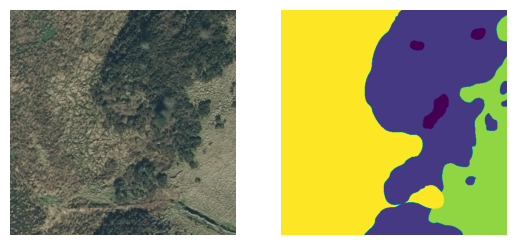

In [50]:
img_o, img_mask = test_ds[800]
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img_o.numpy().transpose(1, 2, 0).astype(int))
ax[1].imshow(img_mask.numpy())

[a.axis('off') for a in ax]
np.bincount(img_mask.ravel()), img_mask.shape